As shown below, the provided dataset is only able to train the model to 69% accuracy. After adding our data for training, accuracy increases to 90%.

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

file = '2_fullstdimg.hdf5'
with h5py.File(file, 'r') as rd:
    XT = np.array(rd['x_train'])
    YT = np.array(rd['y_train'])
    XTE = np.array(rd['x_test'])
    YTE = np.array(rd['y_test'])

XT = XT.astype('float32')/255
XTE = XTE.astype('float32')/255


class_enum = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(XT.shape)
print(YT.shape)
print(XTE.shape)
print(YTE.shape)

(87000, 3, 125, 125)
(87000,)
(1450, 3, 125, 125)
(1450,)


Using built-in transforms for augmentation

In [18]:
form = T.Compose([T.ToPILImage(),
    T.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3, hue=0.3),
    T.RandomRotation(10), 
    T.ToTensor()])

class ASLSetTRAIN(torch.utils.data.Dataset):
    def __init__(self, images, labels, forms):
        'Initialization'
        self.labels = labels
        self.images = images
        self.tform = forms
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = self.tform(torch.from_numpy(img))
        Y = lab
        
        return X, Y

class ASLSetTEST(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        
        return X, Y

train_set = ASLSetTRAIN(XT, YT, form)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)

test_set = ASLSetTEST(XTE, YTE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100, shuffle = False)

loss_func = nn.CrossEntropyLoss()

Epoch: 01: Train Loss: 0.0176, Train Accuracy: 47.689%
            Test Loss: 0.0178, Test Accuracy: 48.897%
Epoch: 02: Train Loss: 0.0042, Train Accuracy: 86.129%
            Test Loss: 0.0179, Test Accuracy: 48.069%
Epoch: 03: Train Loss: 0.0021, Train Accuracy: 93.208%
            Test Loss: 0.0141, Test Accuracy: 60.759%
Epoch: 04: Train Loss: 0.0013, Train Accuracy: 95.797%
            Test Loss: 0.0151, Test Accuracy: 65.103%
Epoch: 05: Train Loss: 0.0009, Train Accuracy: 97.090%
            Test Loss: 0.0133, Test Accuracy: 65.379%
Epoch: 06: Train Loss: 0.0007, Train Accuracy: 97.785%
            Test Loss: 0.0178, Test Accuracy: 61.793%
Epoch: 07: Train Loss: 0.0006, Train Accuracy: 98.154%
            Test Loss: 0.0153, Test Accuracy: 68.483%
Epoch: 08: Train Loss: 0.0005, Train Accuracy: 98.375%
            Test Loss: 0.0173, Test Accuracy: 67.586%
Epoch: 09: Train Loss: 0.0004, Train Accuracy: 98.631%
            Test Loss: 0.0185, Test Accuracy: 62.000%
Epoch: 10: Train Lo

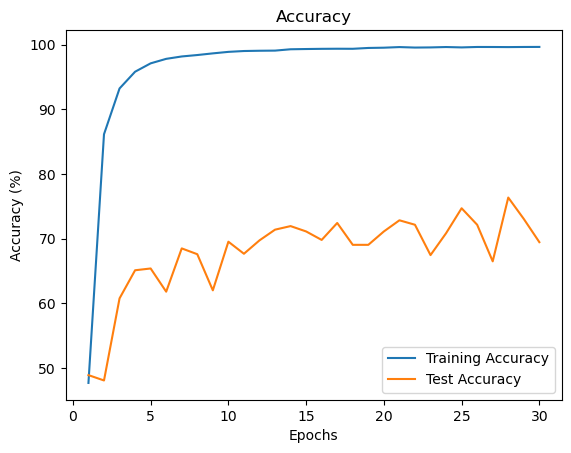

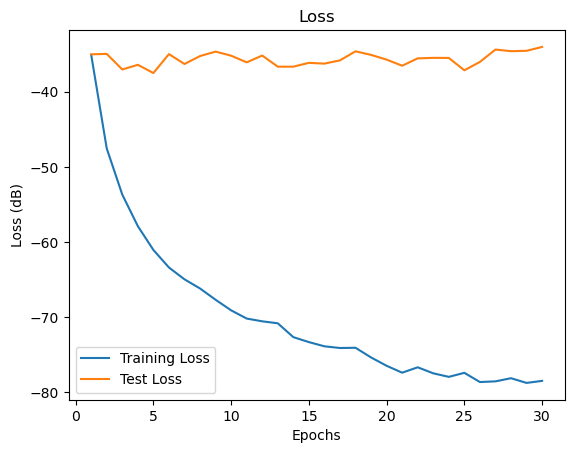

In [19]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()

        self.cnn_3_16 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_16_24= nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_24_32 = nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_32_64 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')

        self.drp = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.batch_16 = nn.BatchNorm2d(16)
        self.batch_24 = nn.BatchNorm2d(24)
        self.batch_32 = nn.BatchNorm2d(32)
        self.batch_64 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(1600, 200) # Will need to change based on CNN Option
        self.fc2 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 29)
        
    def forward(self, x):

        ## CNN Option 3
        x = F.relu(self.cnn_3_16(x))
        x = self.batch_16(self.pool(x))
        x = F.relu(self.cnn_16_24(x))
        x = self.batch_24(self.pool(x))
        x = self.drp(x)
        x = F.relu(self.cnn_24_32(x))
        x = self.batch_32(self.pool(x))
        x = F.relu(self.cnn_32_64(x))
        x = self.batch_64(self.pool(x))
        
        ## Dense Option 2
        x = torch.flatten(x,1)
        x = self.drp(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

model1 = Net1()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.05)

train_loss_arr = []
train_acc_arr = []
test_loss_arr = []
test_acc_arr = []
num_epochs = 30
for epoch in range(num_epochs):
    train_correct = 0
    test_correct = 0
    train_loss = 0
    test_loss = 0
    
    for images, labels in train_loader:
        model1.train()
        #Forward Prop
        outputs = model1(images)
        predictions = torch.max(outputs,1)[1]
        loss = loss_func(outputs,labels)
        train_correct += (predictions == labels).sum().numpy()
        train_loss += loss.data
        
        #Back Prop
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

    for images, labels in test_loader:
        model1.eval()
        #Forward Prop
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        predictions = torch.max(outputs, 1)[1]
        test_correct += (predictions == labels).sum().numpy()
        test_loss += loss.data

    train_loss_arr.append(train_loss/len(train_loader.dataset))
    train_acc_arr.append(train_correct/len(train_loader.dataset))
    test_loss_arr.append(test_loss/len(test_loader.dataset))
    test_acc_arr.append(test_correct/len(test_loader.dataset))

    print(f'Epoch {epoch+1:02d}: Train Loss: {(train_loss/len(train_loader.dataset)):.4f}, Train Accuracy: {(100*train_correct/len(train_loader.dataset)):2.3f}%')
    print("           ", f'Test Loss: {(test_loss/len(test_loader.dataset)):.4f}, Test Accuracy: {(100*test_correct/len(test_loader.dataset)):2.3f}%')
print(f'Final Train Accuracy: {100*train_acc_arr[-1]:2.3f}, Final Test Accuracy: {100*test_acc_arr[-1]:2.3f}')

a = plt.figure(1)
plt.plot(range(1,num_epochs+1), 100*np.array(train_acc_arr), label = "Training Accuracy")
plt.plot(range(1,num_epochs+1), 100*np.array(test_acc_arr), label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()
plt.show()

b = plt.figure(2)
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(train_loss_arr)), label = "Training Loss")
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(test_loss_arr)), label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (dB)")
plt.title("Loss")
plt.legend()
plt.show()

Adding further-curated training images (+12,300) with augmentation

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

file = '4_finalimgf.hdf5'
with h5py.File(file, 'r') as rd:
    XT = np.array(rd['x_train'])
    YT = np.array(rd['y_train'])
    XTE = np.array(rd['x_test'])
    YTE = np.array(rd['y_test'])

XT = XT.astype('float32')/255
XTE = XTE.astype('float32')/255


class_enum = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

print(XT.shape)
print(YT.shape)
print(XTE.shape)
print(YTE.shape)

form = T.Compose([T.ToPILImage(),
    T.ColorJitter(brightness=0.6, contrast=0.4, saturation=0.4, hue=0.4),
    T.RandomRotation(15), 
    T.ToTensor()])

class ASLSetTRAIN(torch.utils.data.Dataset):
    def __init__(self, images, labels, forms):
        'Initialization'
        self.labels = labels
        self.images = images
        self.tform = forms
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = self.tform(torch.from_numpy(img))
        Y = lab
        
        return X, Y

class ASLSetTEST(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        'Initialization'
        self.labels = labels
        self.images = images
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

    def __getitem__(self, index):
        'Generates one sample of data'
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        
        return X, Y

train_set = ASLSetTRAIN(XT, YT, form)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)

test_set = ASLSetTEST(XTE, YTE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100, shuffle = False)

loss_func = nn.CrossEntropyLoss()

(99300, 3, 125, 125)
(99300,)
(1450, 3, 125, 125)
(1450,)


Using device: cuda:0
NVIDIA GeForce RTX 3070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
Epoch 01: Train Loss: 0.0173, Train Accuracy: 48.447%
            Test Loss: 0.0094, Test Accuracy: 61.586%
Epoch 02: Train Loss: 0.0035, Train Accuracy: 88.705%
            Test Loss: 0.0058, Test Accuracy: 82.828%
Epoch 03: Train Loss: 0.0015, Train Accuracy: 95.202%
            Test Loss: 0.0068, Test Accuracy: 81.172%
Epoch 04: Train Loss: 0.0008, Train Accuracy: 97.332%
            Test Loss: 0.0078, Test Accuracy: 78.828%
Epoch 05: Train Loss: 0.0006, Train Accuracy: 98.252%
            Test Loss: 0.0081, Test Accuracy: 78.414%
Epoch 06: Train Loss: 0.0004, Train Accuracy: 98.821%
            Test Loss: 0.0064, Test Accuracy: 80.897%
Epoch 07: Train Loss: 0.0003, Train Accuracy: 99.092%
            Test Loss: 0.0074, Test Accuracy: 83.241%
Epoch 08: Train Loss: 0.0002, Train Accuracy: 99.315%
            Test Loss: 0.0060, Test Accuracy: 85.586%
Epoch 09: Train Loss: 0.0002, Train Accur

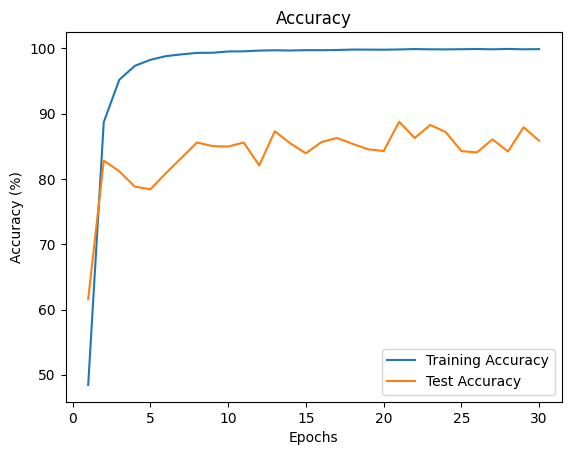

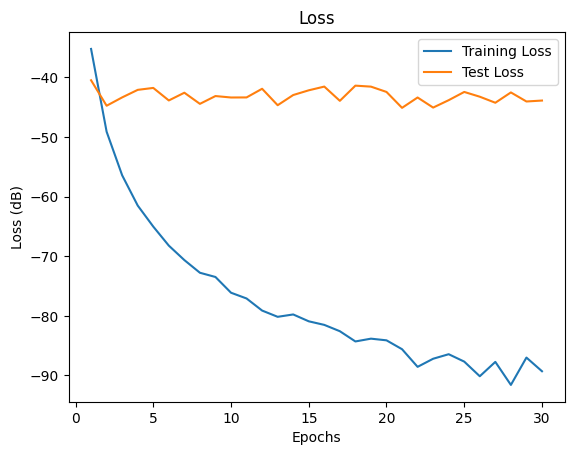

In [2]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()

        self.cnn_3_64 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_64_128 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_128_256 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')
        self.cnn_256_512 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 0, padding_mode = 'zeros')

        self.drp = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.batch_64 = nn.BatchNorm2d(64)
        self.batch_128 = nn.BatchNorm2d(128)
        self.batch_256 = nn.BatchNorm2d(256)
        self.batch_512 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(12800, 800) # Will need to change based on CNN Option
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, 200)
        self.output = nn.Linear(200, 29)
        
    def forward(self, x):

        ## CNN Option 3
        x = F.relu(self.cnn_3_64(x))
        x = self.batch_64(self.pool(x))
        x = F.relu(self.cnn_64_128(x))
        x = self.batch_128(self.pool(x))
        x = self.drp(x)
        x = F.relu(self.cnn_128_256(x))
        x = self.batch_256(self.pool(x))
        x = F.relu(self.cnn_256_512(x))
        x = self.batch_512(self.pool(x))

        ## Dense Option 2
        x = torch.flatten(x,1)
        x = self.drp(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.output(x)

model1 = Net1()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = 0.04)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model1 = model1.to(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

train_loss_arr = []
train_acc_arr = []
test_loss_arr = []
test_acc_arr = []
num_epochs = 30
for epoch in range(num_epochs):
    train_correct = 0
    test_correct = 0
    train_loss = 0
    test_loss = 0
    
    for images, labels in train_loader:
        model1.train()
        images = images.to(device)
        labels = labels.to(device)
        #Forward Prop
        outputs = model1(images)
        loss = loss_func(outputs,labels)

        #Back Prop
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        #Data
        predictions = torch.max(outputs.cpu(),1)[1]
        train_correct += (predictions == labels.cpu()).sum().numpy()
        train_loss += loss.cpu().data
        

    for images, labels in test_loader:
        model1.eval()
        images = images.to(device)
        #Forward Prop
        outputs = model1(images).cpu()
        loss = loss_func(outputs, labels)

        #Data
        predictions = torch.max(outputs, 1)[1]
        test_correct += (predictions == labels).sum().numpy()
        test_loss += loss.data

    train_loss_arr.append(train_loss/len(train_loader.dataset))
    train_acc_arr.append(train_correct/len(train_loader.dataset))
    test_loss_arr.append(test_loss/len(test_loader.dataset))
    test_acc_arr.append(test_correct/len(test_loader.dataset))

    print(f'Epoch {epoch+1:02d}: Train Loss: {(train_loss/len(train_loader.dataset)):.4f}, Train Accuracy: {(100*train_correct/len(train_loader.dataset)):2.3f}%')
    print("           ", f'Test Loss: {(test_loss/len(test_loader.dataset)):.4f}, Test Accuracy: {(100*test_correct/len(test_loader.dataset)):2.3f}%')
print(f'Final Train Accuracy: {100*train_acc_arr[-1]:2.3f}, Final Test Accuracy: {100*test_acc_arr[-1]:2.3f}')

a = plt.figure(1)
plt.plot(range(1,num_epochs+1), 100*np.array(train_acc_arr), label = "Training Accuracy")
plt.plot(range(1,num_epochs+1), 100*np.array(test_acc_arr), label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()
plt.show()

b = plt.figure(2)
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(train_loss_arr)), label = "Training Loss")
plt.plot(range(1,num_epochs+1), 20*np.log10(np.array(test_loss_arr)), label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (dB)")
plt.title("Loss")
plt.legend()
plt.show()

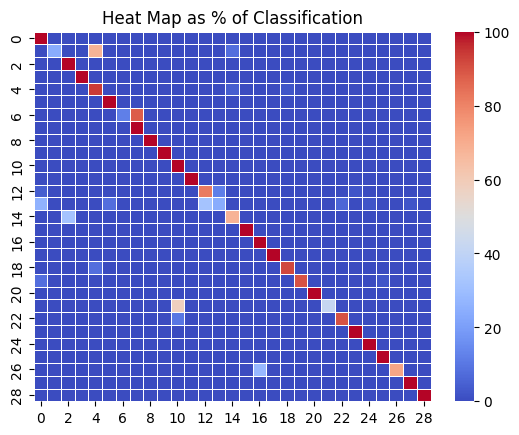

% of Classifications:
A : A (100.00%)
B : E (68.00%)
C : C (100.00%)
D : D (100.00%)
E : E (94.00%)
F : F (100.00%)
G : H (88.00%)
H : H (100.00%)
I : I (100.00%)
J : J (100.00%)
K : K (100.00%)
L : L (100.00%)
M : M (82.00%)
N : M (32.00%)
O : O (68.00%)
P : P (100.00%)
Q : Q (100.00%)
R : R (100.00%)
S : S (92.00%)
T : T (90.00%)
U : U (100.00%)
V : K (58.00%)
W : W (90.00%)
X : X (100.00%)
Y : Y (100.00%)
Z : Z (100.00%)
del : del (72.00%)
nothing : nothing (100.00%)
space : space (100.00%)


In [10]:
import seaborn as sns

conf = np.zeros([29,29])
for images, labels in test_loader:
    model1.eval()
    images = images.to(device)
    outputs = model1(images).cpu()
    predictions = torch.max(outputs, 1)[1]

    for i in range(len(labels)):
        conf[labels[i]][predictions[i]] += 1

for i in range(29):
    conf[i] = 100*conf[i]/np.sum(conf[i])

heat = sns.heatmap(conf, linewidth = 0.5, cmap = 'coolwarm' )
plt.title(f'Heat Map as % of Classification')
plt.show()

# for i in range(29):
#     conf[i][np.argmax(conf[i])] = 0
print('% of Classifications:')
for i in range(29):
    print(class_enum[i], ":", class_enum[np.argmax(conf[i])], f'({conf[i][np.argmax(conf[i])]:2.2f}%)')